data source: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons

In [74]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
import unicodedata
from nltk.corpus import stopwords
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [15]:
logging.getLogger().getEffectiveLevel()

30

In [16]:
%config Application.log_level='INFO'

In [18]:
logging.getLogger().getEffectiveLevel()

30

## data preparation

In [2]:
df = pd.read_csv('data/simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
df.head(3)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...


In [4]:
df = df.dropna().reset_index(drop=True)
df.shape

(131853, 2)

### cleaning

In [37]:
# !python3 -m spacy download en_core_web_md

In [75]:
# nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
def cleaning(doc):
    # lemmatizes and removes stopwords
    # doc needs to be a spacy Doc obj
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    if len(txt) > 2:
        return ' '.join(txt)
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [39]:
# brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [9]:
# t = time()
# txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]
# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.3 mins


In [43]:
# txt = [re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words']]

In [76]:
txt = df['spoken_words'].map(preprocess_sentence)
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(110371, 1)

In [77]:
df_clean.head(3)

,clean
0,actually little sometimes disease magazines ne...
1,bergstrom
2,know although sure like talk touch lesson plan...


### bigrams

In [78]:
from gensim.models.phrases import Phraser, Phrases

In [79]:
sent = [row.split() for row in df_clean['clean']]

In [80]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [81]:
%time bigram = Phraser(phrases)

CPU times: user 3.05 s, sys: 4.86 ms, total: 3.06 s
Wall time: 3.06 s


In [82]:
sentences = bigram[sent]

### frequent words

In [83]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

38350

In [84]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['well', 'like', 'get', 'one', 'know', 'hey', 'right', 'got', 'homer', 'bart']

## training the model

In [85]:
import multiprocessing
from gensim.models import Word2Vec

In [86]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("# CPU Core is ", cores)

# CPU Core is  12


In [87]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-2)

In [88]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} seconds'.format(round((time() - t), 2)))

Time to build vocab: 2.47 seconds


In [89]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} seconds'.format(round((time() - t), 2)))

Time to train the model: 63.91 seconds


In [90]:
# As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient
w2v_model.init_sims(replace=True)

## exploring the model

In [91]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7992547750473022),
 ('nicer', 0.7767024040222168),
 ('cab', 0.7691812515258789),
 ('becky', 0.7613899111747742),
 ('hopeless', 0.7600436210632324),
 ('rude', 0.7587957382202148),
 ('leave_alone', 0.7492135763168335),
 ('sometime', 0.7486610412597656),
 ('crummy', 0.7478622198104858),
 ('snuggle', 0.7477138042449951)]

In [92]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('montgomery_burns', 0.804416298866272),
 ('selected', 0.7972561120986938),
 ('robert', 0.7870327234268188),
 ('charles', 0.7656834125518799),
 ('governor', 0.7429681420326233),
 ('recent', 0.7309332489967346),
 ('elected', 0.7297325134277344),
 ('executive', 0.7281759977340698),
 ('kennedy', 0.7251274585723877),
 ('fellow', 0.7250257730484009)]

In [93]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8069015741348267),
 ('creepy', 0.7614136934280396),
 ('concentrate', 0.7531958818435669),
 ('shh', 0.7490747570991516),
 ('leave_alone', 0.7457764148712158),
 ('saxophone', 0.7443884611129761),
 ('sharing', 0.7398442029953003),
 ('son', 0.7355098724365234),
 ('upset', 0.7352425456047058),
 ('juliet', 0.7340763211250305)]

### similarity

In [95]:
w2v_model.wv.similarity('maggie', 'baby')

0.6374995

In [96]:
w2v_model.wv.similarity('bart', 'nelson')

0.6276669

In [97]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

/Users/wegzheng/.pyenv/versions/3.7.9/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

### Visualization

In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [102]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

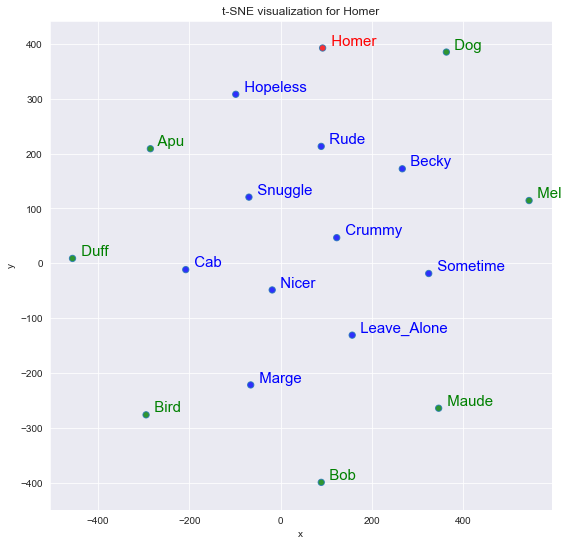

In [105]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'maude', 'bob', 'mel', 'apu', 'duff'])

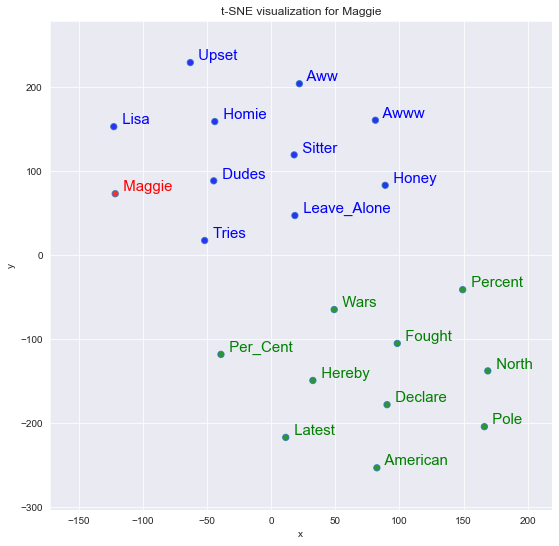

In [106]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])